In [1]:
import pandas as pd
import numpy as np
import warnings
from scipy import stats
from IPython.display import display, HTML
from sklearn import metrics as me

warnings.filterwarnings('ignore')
pd.set_option("display.max_rows",20)
pd.set_option('precision', 4)


%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          append = "",
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title='Confusion matrix {}'.format(append)
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass
    
    #print(cm)

    label = [["\n True Negative", "\n False Positive "],
             ["\n False Negative ", "\n True Positive"]
            ]
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, "{} {}".format(cm[i, j].round(4), label[i][j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value, scenario):
    from sklearn.metrics import confusion_matrix
    append = '{}; \n Total Normal traffic:{}, \n Total Attack Traffic: {}'.format(scenario, 
                                                                            actual_value.groupby(actual_value).count()[0], 
                                                                           actual_value.groupby(actual_value).count()[1])
    
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, ['Normal', 'Attack'], normalize = False, append = append)


In [3]:

def evaluate(model, past_scores, predictions):
    all_scenarios = pd.DataFrame(columns=['Model','Scenarios', 'Number of Features', 'Accuracy', 'MCC', 'Precision', 'Recall'])

    
    def get_best_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.first().sort_values(by='f1_score', ascending=False).head(5)
        return df
    def get_median_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.nth(int(psg.size()[0]/2)).sort_values(by='f1_score', ascending=False).head(5)
        return df
    def get_worst_df(past_scores):
        psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
        df = psg.last().sort_values(by='f1_score', ascending=False).head(5)
        return df
    
    def get_result(past_scores, which='best'):
        if which == 'best':
            df = get_best_df(past_scores)
        elif which == 'median':
            df = get_median_df(past_scores)
        elif which == 'worst':
            df = get_worst_df(past_scores)
            
        #epoch_nof_hidden
        key = int(df.iloc[0]['key'])
        nof = df.iloc[0].name[0]
        hidden = df.iloc[0].name[1]
        
        return "{}_{}_{}".format(key, nof, hidden), nof, df

    def view_data(name, past_scores, which):
        _, _, df = get_result(past_scores, which)
        display(name)
        display(df)
        df1 = df.reset_index().sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features'])
        df1 = df1.first().loc[:,['f1_score', 'time_taken']]
        df1 = df1.rename(index={1:"One", 4:"10%", 8:"20%", 16:"40%", 42:"All"})
        df1.plot(secondary_y = 'time_taken', title=name)
        
    display("Individual Results for each Scenario:-")    
    view_data("   Results for {}: Best case".format(model),past_scores, 'best')
    view_data("   Results for {}: General case".format(model),past_scores,'median')
    view_data("   Results for {}: Worst case".format(model),past_scores,'worst')
        
    def get_score(y_true, y_pred):
        f1 = me.matthews_corrcoef(y_true, y_pred)
        pre = me.precision_score(y_true, y_pred)
        rec = me.recall_score(y_true, y_pred)
        acc = me.accuracy_score(y_true, y_pred)
        return {"MCC":f1, "Precision":pre, "Recall":rec, "Accuracy":acc}
    
    display("Combined Results from all Scenarios for {}".format(model))

    
    
    def accumulate_scenarios(predictions, past_scores, which='best'):
        key, nof, df = get_result(past_scores, which)
        y_true = predictions[key]["Actual"]
        y_pred = predictions[key]["Prediction"]
        y_true = y_true.dropna()
        y_pred = y_pred.dropna()
        
        scores = get_score(y_true, y_pred)
        scores.update({"Scenarios":scenario,"Number of Features":nof,"Model":model})
        plot(y_true, y_pred, scenario)
        return pd.DataFrame(scores, index=[1])
    
    scenario = "Best Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'best'))
    scenario = "General Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'median'))
    scenario = "Worst Result"
    all_scenarios = all_scenarios.append(accumulate_scenarios(predictions, past_scores, 'worst'))
    
    
    display(all_scenarios.set_index(['Model','Scenarios','Number of Features']))
    
    return all_scenarios
    
    
    
    
    

In [4]:
past_scores = pd.read_pickle("dataset/scores/tf_dense_only_nsl_kdd_scores_all.pkl")
predictions = pd.read_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")

'Individual Results for each Scenario:-'

'   Results for Fully Connected Network: Best case'

,,key,train_score,test_score,f1_score,time_taken
no_of_features,hidden_layers,,,,,
1,1,20151210,0.9218,0.7742,0.8711,20.0412
4,1,20151205,0.9050,0.7555,0.8594,15.6686
8,1,20151216,0.8827,0.7447,0.8510,16.0623
42,1,20151228,0.8939,0.7369,0.8470,15.0928
16,1,20151203,0.8212,0.6556,0.7655,14.8755


'   Results for Fully Connected Network: General case'

,,f1_score,key,test_score,time_taken,train_score
no_of_features,hidden_layers,,,,,
4,1,0.8313,20151202,0.7172,15.6686,0.9050
1,1,0.8299,20151205,0.7118,20.0412,0.9218
8,1,0.8195,20151211,0.6966,16.0623,0.8827
42,1,0.7896,20151201,0.6612,15.0928,0.8939
16,1,0.6932,20151221,0.5365,14.8755,0.8212


'   Results for Fully Connected Network: Worst case'

,,key,train_score,test_score,f1_score,time_taken
no_of_features,hidden_layers,,,,,
4,1,20151219,0.9050,0.6011,0.7306,15.6686
8,1,20151213,0.8827,0.5491,0.7067,16.0623
42,1,20151219,0.8939,0.5775,0.7046,15.0928
1,1,20151213,0.9218,0.4589,0.6258,20.0412
16,1,20151213,0.8212,0.3072,0.4626,14.8755


'Combined Results from all Scenarios for Fully Connected Network'

Accuracy     MCC  \
Model                   Scenarios      Number of Features                     
Fully Connected Network Best Result    1                     0.7742  0.1635   
                        General Result 4                     0.7172  0.0780   
                        Worst Result   4                     0.6011 -0.0243   

                                                           Precision  Recall  
Model                   Scenarios      Number of Features                     
Fully Connected Network Best Result    1                      0.9971  0.7735  
                        General Result 4                      0.9637  0.7309  
                        Worst Result   4                      0.6831  0.7853

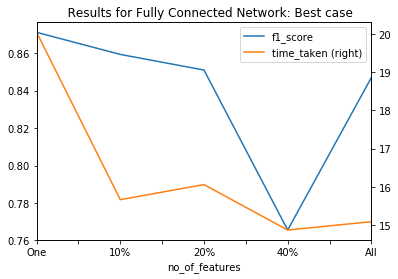

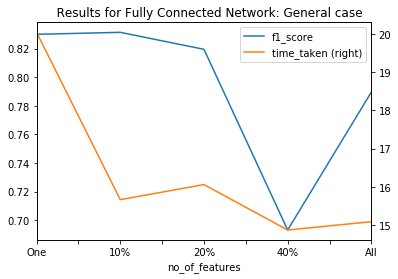

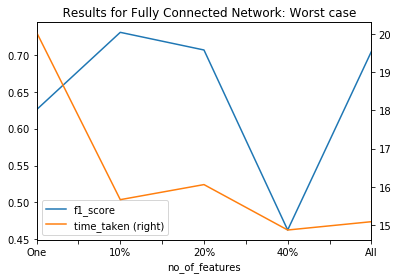

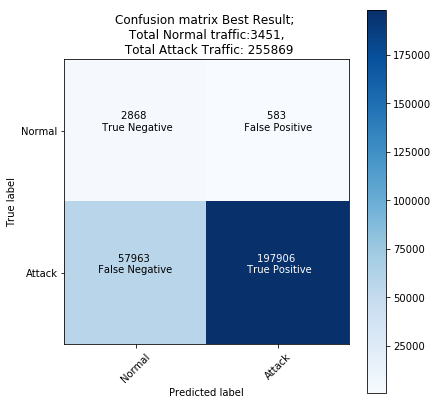

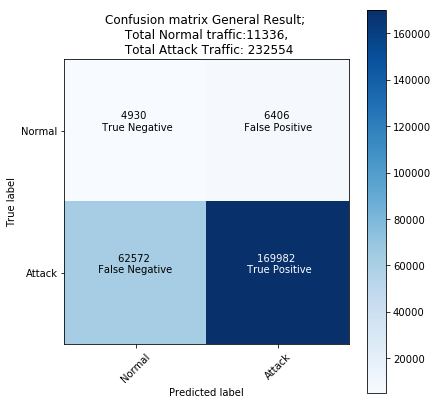

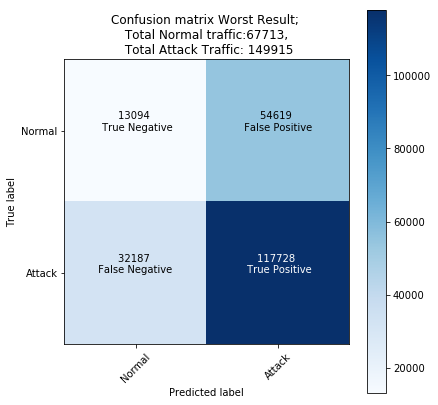

In [5]:
all_scenarios_fcn = evaluate("Fully Connected Network", past_scores, predictions)

psg = past_scores.sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features', 'hidden_layers'])
df = psg.first().sort_values(by='f1_score', ascending=False).head(5)
df1 = df.reset_index().sort_values(by='f1_score', ascending=False).groupby(by=['no_of_features'])
df1 = df1.first().loc[:,['f1_score', 'time_taken']]
df1 = df1.rename(index={1:"One", 4:"10%", 8:"20%", 16:"40%", 42:"All"})
df1.plot(secondary_y = 'time_taken', table=True)

In [6]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_dense_trained_together_nsl_kdd_scores-all.pkl")
predictions = pd.read_pickle("dataset/tf_vae_dense_trained_together_nsl_kdd_predictions.pkl")

'Individual Results for each Scenario:-'

'   Results for VAE with Softmax: Best case'

,,key,train_score,test_score,f1_score,time_taken
no_of_features,hidden_layers,,,,,
1,1,20151213,0.9953,0.9906,0.9953,30.2529
42,3,20151225,0.9864,0.9766,0.9882,44.9156
16,3,20151225,0.9733,0.9585,0.9788,42.9568
8,3,20151225,0.9489,0.9485,0.9735,43.2247
4,1,20151225,0.9234,0.9344,0.9660,32.1324


'   Results for VAE with Softmax: General case'

,,f1_score,key,test_score,time_taken,train_score
no_of_features,hidden_layers,,,,,
1,1,0.9903,20151215,0.9808,30.2529,0.9953
42,3,0.9817,20151228,0.9641,44.9156,0.9864
16,3,0.9683,20151207,0.9387,42.9568,0.9733
8,3,0.9574,20151215,0.9185,43.2247,0.9489
4,1,0.9487,20151209,0.9028,32.1324,0.9234


'   Results for VAE with Softmax: Worst case'

key  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
4              3              20151219       0.8642      0.7686    0.8465   
               1              20151219       0.9234      0.7356    0.8355   
8              3              20151219       0.9489      0.7289    0.8312   
16             3              20151219       0.9733      0.7133    0.8235   
42             3              20151219       0.9864      0.7034    0.8220   

                              time_taken  
no_of_features hidden_layers              
4              3                 42.9294  
               1                 32.1324  
8              3                 43.2247  
16             3                 42.9568  
42             3                 44.9156

'Combined Results from all Scenarios for VAE with Softmax'

Accuracy     MCC  \
Model            Scenarios      Number of Features                     
VAE with Softmax Best Result    1                     0.9906  0.0321   
                 General Result 1                     0.9808 -0.0004   
                 Worst Result   4                     0.7686  0.4156   

                                                    Precision  Recall  
Model            Scenarios      Number of Features                     
VAE with Softmax Best Result    1                      0.9906  1.0000  
                 General Result 1                      0.9808  1.0000  
                 Worst Result   4                      0.7794  0.9263

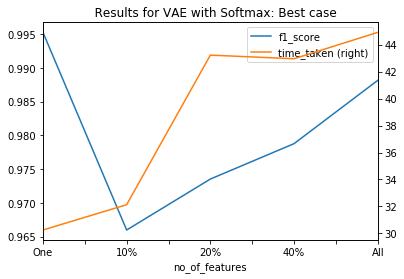

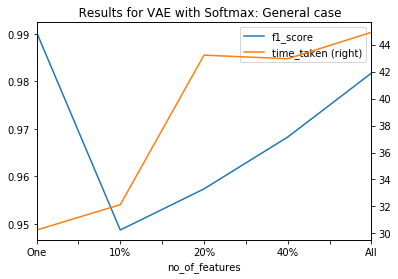

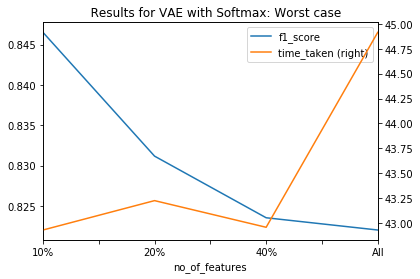

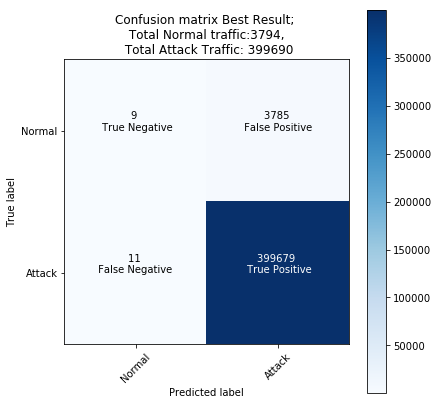

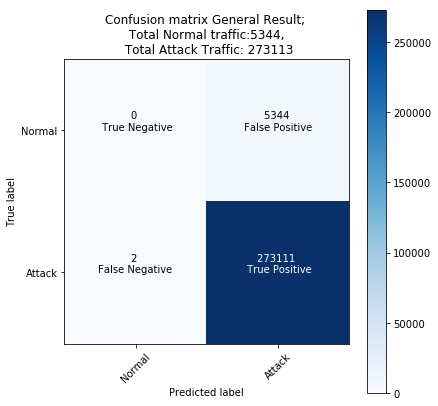

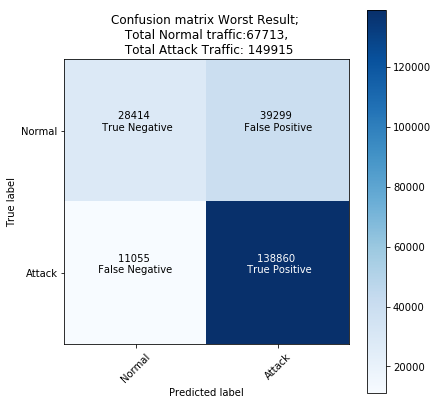

In [7]:
all_scenarios_vae_sm = evaluate("VAE with Softmax", past_scores, predictions)

In [8]:
past_scores = pd.read_pickle("dataset/scores/tf_vae_only_vae_loss_nsl_kdd_scores_all.pkl")
predictions = pd.read_pickle("dataset/tf_vae_only_vae_loss_nsl_kdd_predictions.pkl")

'Individual Results for each Scenario:-'

'   Results for VAE with Label Generation: Best case'

key  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
1              1              20151213       0.9942      0.9906    0.9953   
               3              20151213       0.9931      0.9906    0.9953   
4              3              20151213       0.9931      0.9906    0.9953   
8              3              20151213       0.9942      0.9906    0.9953   
16             3              20151213       0.9930      0.9906    0.9953   

                              time_taken  
no_of_features hidden_layers              
1              1                 27.8164  
               3                 35.3810  
4              3                 35.2472  
8              3                 36.4201  
16             3                 37.0005

'   Results for VAE with Label Generation: General case'

f1_score       key  test_score  time_taken  \
no_of_features hidden_layers                                               
1              1                0.9903  20151215      0.9808     27.8164   
               3                0.9903  20151215      0.9808     35.3810   
4              3                0.9903  20151215      0.9808     35.2472   
8              3                0.9903  20151215      0.9808     36.4201   
16             3                0.9903  20151215      0.9808     37.0005   

                              train_score  
no_of_features hidden_layers               
1              1                   0.9942  
               3                   0.9931  
4              3                   0.9931  
8              3                   0.9942  
16             3                   0.9930

'   Results for VAE with Label Generation: Worst case'

key  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
42             3              20151219       0.9931      0.6889    0.8158   
1              1              20151219       0.9942      0.6889    0.8158   
               3              20151219       0.9931      0.6889    0.8158   
4              3              20151219       0.9931      0.6889    0.8158   
8              3              20151219       0.9942      0.6889    0.8158   

                              time_taken  
no_of_features hidden_layers              
42             3                 39.8449  
1              1                 27.8164  
               3                 35.3810  
4              3                 35.2472  
8              3                 36.4201

'Combined Results from all Scenarios for VAE with Label Generation'

Accuracy     MCC  \
Model                     Scenarios      Number of Features                     
VAE with Label Generation Best Result    1                     0.9906  0.0000   
                          General Result 1                     0.9808  0.0000   
                          Worst Result   42                    0.6889  0.0032   

                                                             Precision  Recall  
Model                     Scenarios      Number of Features                     
VAE with Label Generation Best Result    1                      0.9906     1.0  
                          General Result 1                      0.9808     1.0  
                          Worst Result   42                     0.6889     1.0

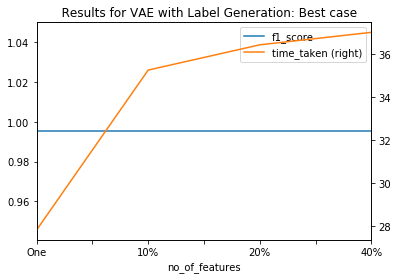

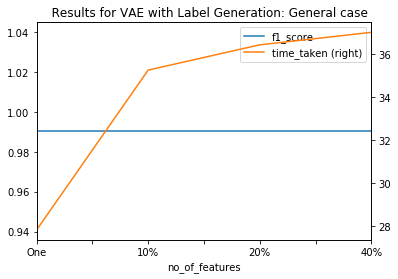

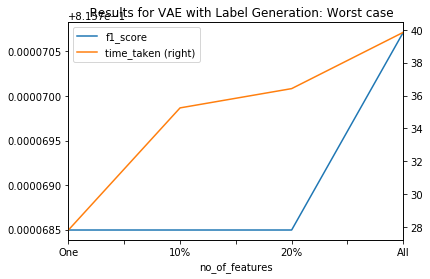

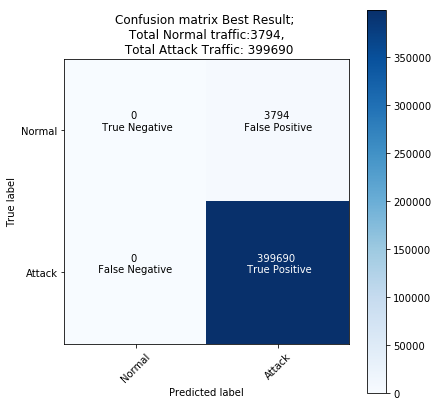

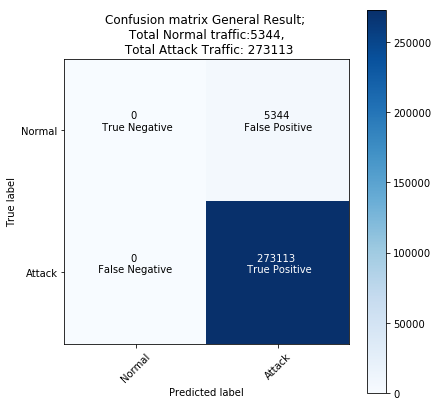

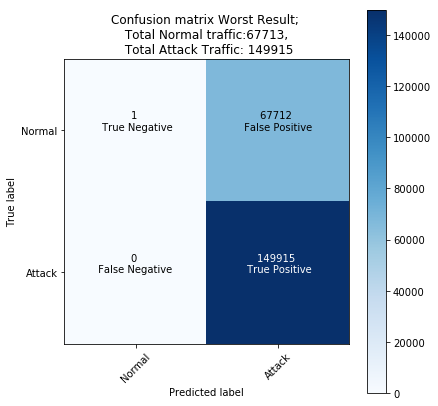

In [9]:
all_scenarios_vae = evaluate("VAE with Label Generation", past_scores, predictions)

In [10]:
past_scores = pd.read_pickle("dataset/scores/tf_lstm_nsl_kdd-orig_all.pkl")
predictions = pd.read_pickle("dataset/tf_lstm_nsl_kdd_predictions.pkl")

'Individual Results for each Scenario:-'

'   Results for LSTM Seq2Seq: Best case'

key  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
1              3              20151230       1.0000      1.0000       1.0   
               1              20151202       0.9999      0.9999       1.0   

                              time_taken  
no_of_features hidden_layers              
1              3                  7.5321  
               1                  5.2221

'   Results for LSTM Seq2Seq: General case'

f1_score       key  test_score  time_taken  \
no_of_features hidden_layers                                               
1              3                1.0000  20151222      1.0000      7.5321   
               1                0.9997  20151231      0.9995      5.2221   

                              train_score  
no_of_features hidden_layers               
1              3                   1.0000  
               1                   0.9999

'   Results for LSTM Seq2Seq: Worst case'

key  train_score  test_score  f1_score  \
no_of_features hidden_layers                                                
1              3              20151213       1.0000       1.000    1.0000   
               1              20151217       0.9999       0.995    0.9974   

                              time_taken  
no_of_features hidden_layers              
1              3                  7.5321  
               1                  5.2221

'Combined Results from all Scenarios for LSTM Seq2Seq'

Accuracy     MCC  Precision  \
Model        Scenarios      Number of Features                                
LSTM Seq2Seq Best Result    1                        1.0  1.0000        1.0   
             General Result 1                        1.0  1.0000        1.0   
             Worst Result   1                        1.0  0.9981        1.0   

                                                Recall  
Model        Scenarios      Number of Features          
LSTM Seq2Seq Best Result    1                      1.0  
             General Result 1                      1.0  
             Worst Result   1                      1.0

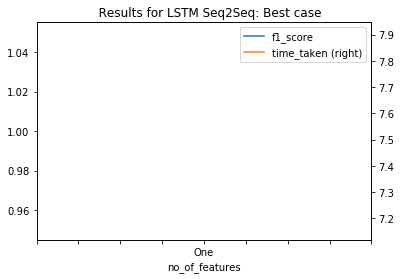

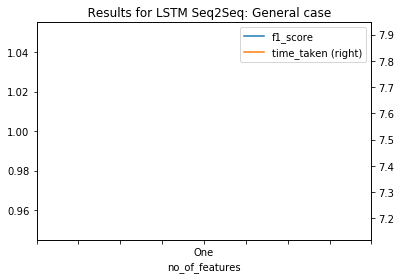

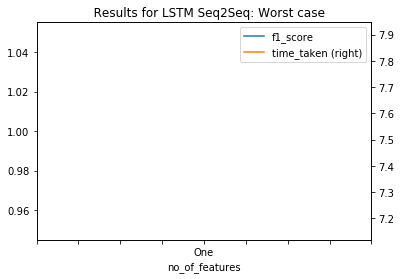

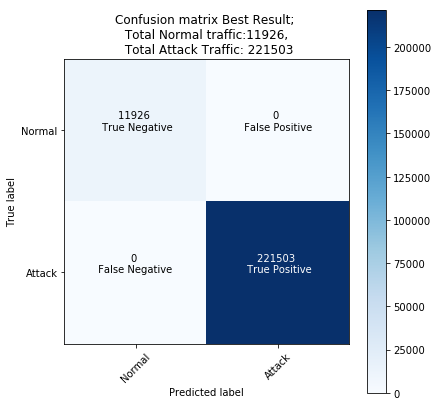

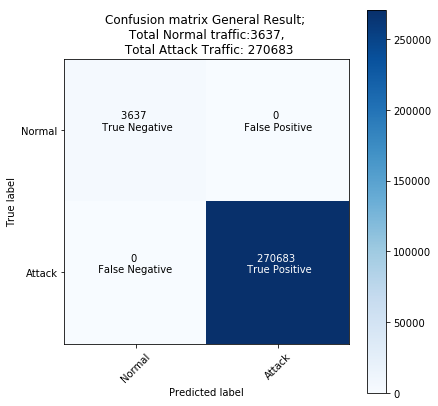

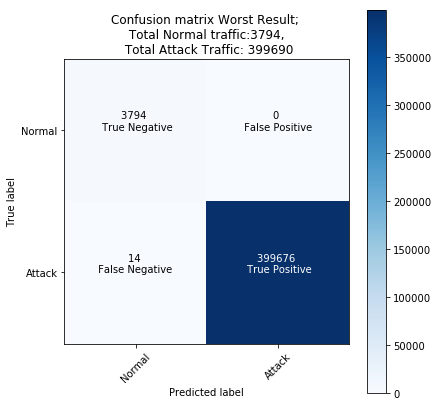

In [11]:
all_scenarios_lstm = evaluate("LSTM Seq2Seq", past_scores, predictions)

In [12]:
all_scenarios = pd.concat([all_scenarios_fcn, all_scenarios_vae_sm, all_scenarios_vae, all_scenarios_lstm],axis=0)

In [13]:
all_scenarios_display = all_scenarios.set_index(['Model', 'Scenarios', 'Number of Features'])
all_scenarios_display

Accuracy     MCC  \
Model                     Scenarios      Number of Features                     
Fully Connected Network   Best Result    1                     0.7742  0.1635   
                          General Result 4                     0.7172  0.0780   
                          Worst Result   4                     0.6011 -0.0243   
VAE with Softmax          Best Result    1                     0.9906  0.0321   
                          General Result 1                     0.9808 -0.0004   
                          Worst Result   4                     0.7686  0.4156   
VAE with Label Generation Best Result    1                     0.9906  0.0000   
                          General Result 1                     0.9808  0.0000   
                          Worst Result   42                    0.6889  0.0032   
LSTM Seq2Seq              Best Result    1                     1.0000  1.0000   
                          General Result 1                     1.0000  1.0000   
                          Worst Result   1                     1.0000  0.9981   

                                                             Precision  Recall  
Model                     Scenarios      Number of Features                     
Fully Connected Network   Best Result    1                      0.9971  0.7735  
                          General Result 4                      0.9637  0.7309  
                          Worst Result   4                      0.6831  0.7853  
VAE with Softmax          Best Result    1                      0.9906  1.0000  
                          General Result 1                      0.9808  1.0000  
                          Worst Result   4                      0.7794  0.9263  
VAE with Label Generation Best Result    1                      0.9906  1.0000  
                          General Result 1                      0.9808  1.0000  
                          Worst Result   42                     0.6889  1.0000  
LSTM Seq2Seq              Best Result    1                      1.0000  1.0000  
                          General Result 1                      1.0000  1.0000  
                          Worst Result   1                      1.0000  1.0000

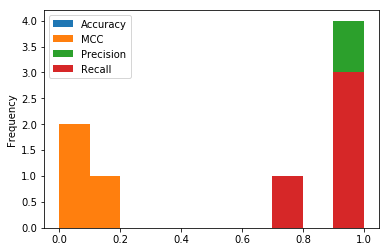

In [14]:
all_scenarios_best = all_scenarios.set_index(['Scenarios', 'Model', 'Number of Features'])
all_scenarios_best.loc['Best Result'].plot(kind='hist')